# [실습] DecisionTree
## 사용자 행동 인식 데이터 세트

In [103]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import os
print(os.getcwd())

c:\Users\user\PJT\Study\06_ML


In [3]:
feature_name_df = pd.read_csv('./db/human_activity/features.txt',sep='\s+', header=None, names=['column_index','column_name'])

feature_name = feature_name_df.iloc[:,1].head(10)
print('전체 피처에서 10개만 추출:', feature_name[:10])

전체 피처에서 10개만 추출: 0    tBodyAcc-mean()-X
1    tBodyAcc-mean()-Y
2    tBodyAcc-mean()-Z
3     tBodyAcc-std()-X
4     tBodyAcc-std()-Y
5     tBodyAcc-std()-Z
6     tBodyAcc-mad()-X
7     tBodyAcc-mad()-Y
8     tBodyAcc-mad()-Z
9     tBodyAcc-max()-X
Name: column_name, dtype: object


In [4]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print('중복된 열 수 :', feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

중복된 열 수 : column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


### 중복된 column name 변경

In [46]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df


In [63]:
def get_human_dataset():
    # 공백을 기준으로 분리
    feature_name_df = pd.read_csv('./db/human_activity/features.txt',sep='\s+', header=None, names=['column_index','column_name'])

    # 중복된 피처명 수정
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    # print(len(np.unique(feature_name_df.column_name)))
    # print(len(np.unique(new_feature_name_df.column_name)))

    # DataFrame에 피처명을 칼럼에 부여하기위해 리스트 객체로 다시 변환
    feature_name= new_feature_name_df.iloc[:,1].values.tolist()

    # Test / Train data loading
    X_train = pd.read_csv('./db/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./db/human_activity/test/X_test.txt', sep='\s+', names=feature_name)

    y_train = pd.read_csv('./db/human_activity/train/y_train.txt', sep='\s+', names=['action'])
    y_test = pd.read_csv('./db/human_activity/test/y_test.txt', sep='\s+', names=['action'])
    print('shape : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [64]:
X_train, X_test, y_train, y_test = get_human_dataset()

shape :  (7352, 561) (2947, 561) (7352, 1) (2947, 1)


In [65]:
print('## 학습피처 데이터셋 info()')
print(X_train.info())

## 학습피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [68]:
print(y_train.action.value_counts())
# 결과 값들이 비교적 고르게 분포함

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [72]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print('결정트리 예측 정확도 {0:4f}'.format(accuracy))
print('DecisionTreeClassifier parameter \n:',model.get_params())

결정트리 예측 정확도 0.851714
DecisionTreeClassifier parameter 
: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


### GridSearchCV를 이용해 결정트리의 깊이 조절에 따른 정확도 비교를 해보자.
- max_depth가 8 일때 5개 폴드 세트의 최고 평균 정확도 결과가 85%이다.
- max_depth 8에서 가장 좋은 성능을 가짐.
- 별도의 테스트 데이터에서 depth에 따른 성능비교를 해보자.

In [88]:
params = {
    'max_depth' : [6,8,10,12],
    'min_samples_split' :[16,24]
}

grid_cv = GridSearchCV(model,param_grid=params, scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 parameter : \n', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 parameter : 
 {'max_depth': 8, 'min_samples_split': 16}


In [93]:
# GridSearchCV 객체의 cv_result_ 속성을 df로 생성
cv_result_df = pd.DataFrame(grid_cv.cv_results_)
cv_result_df.columns
cv_result_df[['param_max_depth','param_min_samples_split','mean_test_score']]

,param_max_depth,param_min_samples_split,mean_test_score
0,6,16,0.847662
1,6,24,0.846575
2,8,16,0.854879
3,8,24,0.851342
4,10,16,0.852705
5,10,24,0.854064
6,12,16,0.845768
7,12,24,0.846175


In [94]:
max_depth = [6,8,10,12,16,20,24]
# max_depth 갑을 번화시키면서 그때마다 학습과 테스트 세트에서의 예측성능 예측
for depth in max_depth:
    best_model = DecisionTreeClassifier(max_depth= depth, min_samples_split=16)
    best_model.fit(X_train,y_train)
    pred = best_model.predict(X_test)
    accuracy = accuracy_score(pred, y_test)
    print('max_depth : {0} / accuracy : {1:.4f}'.format(depth, accuracy))

max_depth : 6 / accuracy : 0.8551
max_depth : 8 / accuracy : 0.8731
max_depth : 10 / accuracy : 0.8646
max_depth : 12 / accuracy : 0.8653
max_depth : 16 / accuracy : 0.8568
max_depth : 20 / accuracy : 0.8568
max_depth : 24 / accuracy : 0.8575


### 어떤 피쳐가 영향력이 있는지 확인해보자.

In [96]:
best_model = grid_cv.best_estimator_
best_model.fit(X_train,y_train)
pred = best_model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print('accuracy :', accuracy)


accuracy : 0.8717339667458432


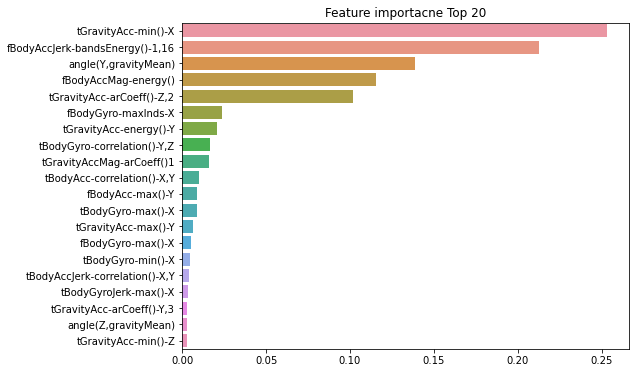

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

ftr_importance_values = best_model.feature_importances_

# Top 중요도로 정렬을 쉽게하고 seaborn의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)
top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importacne Top 20')
sns.barplot(x=top20, y=top20.index)
plt.show()